In [1]:
%matplotlib inline

from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt

import numpy as np
from sklearn import preprocessing, model_selection, neighbors, svm
from sklearn.pipeline import Pipeline
from sklearn import linear_model, decomposition, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, RobustScaler


np.random.seed(0)

print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


Automatically created module for IPython interactive environment


In [2]:
df_rain = pd.read_csv('rain_dataframe.csv', header=0, parse_dates=True,
    index_col=0)
df_rain.head()

,date_rain,rain,t_rain-8,t_rain-7,t_rain-6,t_rain-5,t_rain-4,t_rain-3,t_rain-2,t_rain-1,t_rain0
1,2014-12-28,0.0,1.1,0.3,3.3,4.1,0.3,0.0,10.1,0.4,0.0
2,2015-01-02,0.3,0.0,10.1,0.4,0.0,0.0,0.0,0.7,5.1,0.3
3,2015-02-04,0.0,0.4,3.8,8.8,1.7,0.5,0.0,0.0,1.3,0.0
4,2015-02-16,0.2,0.0,0.0,0.0,0.0,0.0,4.5,0.0,6.2,0.2
5,2015-02-28,1.7,2.5,0.2,10.7,6.8,6.0,1.8,7.1,0.1,1.7


In [3]:
df_evap = pd.read_csv('evap_dataframe.csv', header=0, parse_dates=True,
    index_col=0)
df_evap.head()

,date_evap,evap,t_evap-8,t_evap-7,t_evap-6,t_evap-5,t_evap-4,t_evap-3,t_evap-2,t_evap-1,t_evap0
1,2014-12-28,0.0,0.4,0.9,0.9,0.6,0.4,0.2,0.5,0.2,0.0
2,2015-01-02,0.6,0.2,0.5,0.2,0.0,0.4,0.6,1.2,0.8,0.6
3,2015-02-04,0.5,0.4,0.6,0.8,0.7,0.8,0.5,0.4,0.4,0.5
4,2015-02-16,0.8,0.3,0.5,0.6,0.7,1.0,0.9,0.7,0.7,0.8
5,2015-02-28,1.2,0.8,1.1,0.9,1.0,1.3,0.8,1.0,0.9,1.2


In [4]:
df_wlevel = pd.read_csv('wlevel_dataframe.csv', header=0, parse_dates=True,
    index_col=0)
df_wlevel.head()

,date_wlevel,w_level,t_wlevel-8,t_wlevel-7,t_wlevel-6,t_wlevel-5,t_wlevel-4,t_wlevel-3,t_wlevel-2,t_wlevel-1,t_wlevel0
1,2014-12-28,33.814,33.622,33.587,33.563,33.594,33.686,33.727,33.724,33.784,33.814
2,2015-01-02,33.699,33.727,33.724,33.784,33.814,33.787,33.751,33.715,33.692,33.699
3,2015-02-04,33.659,33.788,33.751,33.735,33.752,33.775,33.754,33.718,33.689,33.659
4,2015-02-16,33.125,33.470,33.421,33.369,33.319,33.268,33.217,33.190,33.145,33.125
5,2015-02-28,33.391,33.024,33.008,32.990,33.061,33.166,33.212,33.284,33.377,33.391


In [5]:
# Import the excel file and call it xls_file
xls_file = pd.ExcelFile('classes.xls')
xls_file
xls_file.sheet_names
df_classes = xls_file.parse('Sheet1')
df_classes.head()

,Date,Class
0,2014-11-22,1
1,2014-12-28,1
2,2015-01-02,1
3,2015-02-04,1
4,2015-02-16,0


In [6]:
#clean up and remove unnessessary columns
df_rain.reset_index(drop=True, inplace=True)
df_evap.reset_index(drop=True, inplace=True)
df_wlevel.reset_index(drop=True, inplace=True)
df_classes.reset_index(drop=True, inplace=True)

df = pd.concat([df_classes,df_rain,df_evap,df_wlevel], axis=1)
df.drop('date_wlevel', axis=1, inplace=True)
df.drop('date_evap', axis=1, inplace=True)
df.drop('date_rain', axis=1, inplace=True)
df.drop('w_level', axis=1, inplace=True)
df.drop('evap', axis=1, inplace=True)
df.drop('rain', axis=1, inplace=True)
df.drop(66, axis=0, inplace=True)
df.to_csv('concat.csv')

In [7]:
X = np.array(df.drop(['Class', 'Date'], 1)) #Everything but the class
y = np.array(df['Class'])           #Class  
print(X)

[[  1.1     0.3     3.3   ...,  33.724  33.784  33.814]
 [  0.     10.1     0.4   ...,  33.715  33.692  33.699]
 [  0.4     3.8     8.8   ...,  33.718  33.689  33.659]
 ..., 
 [  4.8     1.8     6.    ...,  32.873  32.887  32.901]
 [  0.      0.      0.    ...,  32.94   32.92   32.902]
 [  0.      0.      9.    ...,  32.902  32.876  32.87 ]]


In [8]:
estimators = [('reduce_dim', PCA()), ('clf', SVC())]
pipe = Pipeline(estimators)
pipe 

Pipeline(steps=[('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

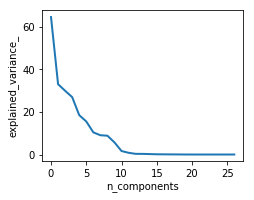

In [10]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3)

pca1 = PCA()
pca = decomposition.PCA()
pca.fit(X_train)
X_t_train = pca.transform(X_train)
X_t_test = pca.transform(X_test)
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

In [11]:
clf = SVC()
clf.set_params(kernel='linear').fit(X, y)  
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [12]:
clf.set_params(kernel='linear').fit(X, y)  
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
clf.fit(X_t_train, y_train)
print('score', clf.score(X_t_test, y_test))
print('pred label', clf.predict(X_t_test))

score 1.0
pred label [0 1 1 0 0 1 0 0 1 0 1 0 1 0 0 1 0 1 0 1]


In [18]:
confidence = clf.score(X_t_test, y_test)
print(confidence)

1.0


In [19]:
print('Prediction: ', clf.predict(X[[-1]]))
print(y[-1])

Prediction:  [0]
0


In [20]:
print('Prediction: ', clf.predict(X[[50]]))
print(y[50])

Prediction:  [0]
0


In [21]:
print('Prediction: ', clf.predict(X[[25]]))
print(y[25])

Prediction:  [0]
1
